# <h1><b><I> General Setup

## Imports and general setup

In [1]:
import os, sys, time
from tqdm import tqdm


from gammabayes.likelihoods.instrument_response_funcs import log_bkg_CCR_dist, log_edisp, log_psf, single_loglikelihood
from scipy import interpolate, special, integrate
from gammabayes.utils.event_axes import log10eaxistrue, longitudeaxistrue, latitudeaxistrue, log10eaxis, longitudeaxis, latitudeaxis, makelogjacob
from gammabayes.utils.config_utils import read_config_file
from gammabayes.hyper_inference.hyperparameter_likelihood import hyperparameter_likelihood
from gammabayes.priors.prior import discrete_logprior
from gammabayes.likelihoods.discrete_loglikelihood import discrete_loglikelihood
from gammabayes.dark_matter.SS_DM_Constructor import SS_DM_dist
from gammabayes.utils.plotting import logdensity_matrix_plot, plot_loge_lon_lat_prior_samples, plot_loge_lon_lat_recon_samples
from gammabayes.utils.utils import bin_centres_to_edges
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from astropy import units as u
from scipy import special,stats
from scipy.integrate import simps
from matplotlib import cm
from tqdm.autonotebook import tqdm as notebook_tqdm

import functools, random
from multiprocessing import Pool, freeze_support
import multiprocessing
import pandas as pd
random.seed(0)

/Users/lpin0002/anaconda3/envs/testywesty/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pkg_resources

resource_file_path = pkg_resources.resource_filename('gammabayes', 'package_data')

astrophysicalbackground = np.load(f"{resource_file_path}/unnormalised_astrophysicalbackground.npy")
psfnormalisationvalues = np.load(f"{resource_file_path}/psfnormalisation.npy")
edispnormalisationvalues = np.load(f"{resource_file_path}/edispnormalisation.npy")

In [3]:
log10emeshtrue, lonmeshtrue, latmeshtrue = np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij')
lonmeshrecon, latmeshrecon = np.meshgrid(longitudeaxis, latitudeaxis, indexing='ij')

logjacobtrue = np.meshgrid(np.log(10**log10eaxistrue), longitudeaxistrue, latitudeaxistrue, indexing='ij')[0]

print(lonmeshtrue.shape, lonmeshrecon.shape)

(601, 35, 30) (18, 15)


## Script Parameter Setup

In [4]:
config_inputs = read_config_file('example_run_script.yaml')


startertimer = time.perf_counter()
print(startertimer)

file path: example_run_script.yaml
228540.428464625


# <h1><b>Simulation

## Setup

### Background setup

In [5]:
unnormed_logbkgpriorvalues = np.logaddexp(np.squeeze(log_bkg_CCR_dist(log10emeshtrue, lonmeshtrue,latmeshtrue)),np.log(astrophysicalbackground))


logbkgpriorvalues = unnormed_logbkgpriorvalues - special.logsumexp(unnormed_logbkgpriorvalues+logjacobtrue)

logbkgpriorvalues.shape


nuisancemesh = np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij')

unnormed_logbkgpriorvalues = np.logaddexp(np.squeeze(log_bkg_CCR_dist(*nuisancemesh)),np.log(astrophysicalbackground))
# unnormed_logbkgpriorvalues = np.squeeze(log_bkg_CCR_dist(*nuisancemesh))


logbkgfunc_annoying = interpolate.RegularGridInterpolator((log10eaxistrue, longitudeaxistrue, latitudeaxistrue), np.exp(unnormed_logbkgpriorvalues))
logbkgfunc = lambda logenergy, longitude, latitude: np.log(logbkgfunc_annoying((logenergy, longitude, latitude)))


bkg_prior = discrete_logprior(logfunction=logbkgfunc, name='Background Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), 
                               axes_names=['energy', 'lon', 'lat'], logjacob=logjacobtrue)

### Signal Setup

In [6]:
SS_DM_dist_instance= SS_DM_dist(longitudeaxistrue, latitudeaxistrue)
logDMpriorfunc = SS_DM_dist_instance.func_setup()

In [7]:
DM_prior = discrete_logprior(logfunction=logDMpriorfunc, name='Scalar Singlet Dark Matter Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), axes_names=['energy', 'lon', 'lat'],
                               default_hyperparameter_values=(config_inputs['logmass'],), hyperparameter_names=['mass'], logjacob=logjacobtrue)
DM_prior

(0.5,)


discrete log prior class
----------------------------
name = Scalar Singlet Dark Matter Prior
logfunction type is <function SS_DM_dist.func_setup.<locals>.DM_signal_dist at 0x1555d3920>
input units of None
over axes ['energy', 'lon', 'lat']
with hyperparameter(s) ['mass']

## True Value Simulation

In [8]:
siglogevals,siglonvals,siglatvals  = DM_prior.sample(int(round(config_inputs['signalfraction']*config_inputs['Nevents'])))

In [9]:
bkglogevals,bkglonvals,bkglatvals  = bkg_prior.sample(int(round((1-config_inputs['signalfraction'])*config_inputs['Nevents'])))

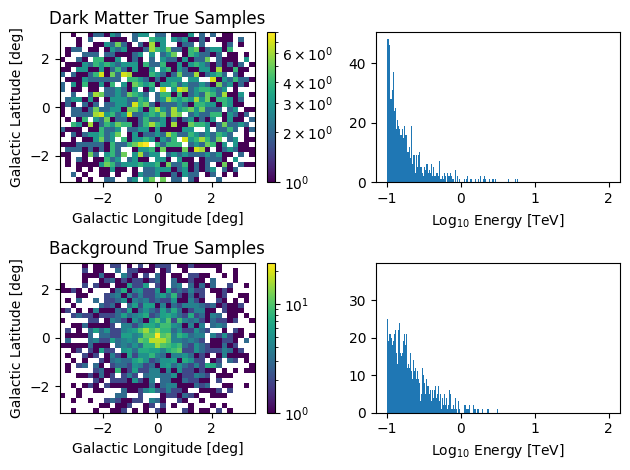

In [10]:
plot_loge_lon_lat_prior_samples(((bkglogevals, bkglonvals, bkglatvals),(siglogevals, siglonvals,siglatvals)), 
    twodhist_xlabel='Galactic Longitude [deg]', twodhist_ylabel='Galactic Latitude [deg]', 
    onedhist_xlabel = r'Log$_{10}$ Energy [TeV]',
    dist_names = ('Dark Matter True Samples', 'Background True Samples'),
    log10eaxistrue=log10eaxistrue, longitudeaxistrue=longitudeaxistrue, latitudeaxistrue=latitudeaxistrue, 
    )
plt.show()

## Reconstructed Value Simulation

In [11]:
logjacob = np.meshgrid(np.log(10**log10eaxis), longitudeaxis, latitudeaxis, indexing='ij')[0]

In [12]:
edisp_like = discrete_loglikelihood(logfunction=log_edisp, 
                                    axes=(log10eaxis,), axes_names='log10E recon',
                                    name='energy dispersion',
                                    dependent_axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), logjacob=logjacob,
                                    dependent_axes_names = ['log10E true', 'lon', 'lat'])

Number of input dimensions 1


In [13]:
psf_like = discrete_loglikelihood(logfunction=log_psf, 
                                    axes=(longitudeaxis, latitudeaxis), axes_names=['longitude recon', 'latitude recon'],
                                    name='point spread function ',
                                    dependent_axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,),
                                    dependent_axes_names = ['log10E true', 'lon', 'lat'])
psf_like

Number of input dimensions 2


discrete log likelihood class
---------------------------------
name = point spread function 
logfunction type is <function log_psf at 0x1514736a0>
input units of None
over axes ['longitude recon', 'latitude recon']
with dependent axes ['log10E true', 'lon', 'lat']

### Signal

In [15]:
signal_lon_measured = []
signal_lat_measured = []

signal_log10e_measured = [np.squeeze(edisp_like.sample((logeval,*coord,), numsamples=1)) for logeval,coord  in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=int(config_inputs['signalfraction']*config_inputs['Nevents']))]

    
sig_lonlat_psf_samples =  [psf_like.sample((logeval,*coord,), 1).tolist() for logeval,coord  in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=config_inputs['signalfraction']*config_inputs['Nevents'])]

for sig_lonlat_psf_sample in sig_lonlat_psf_samples:
    signal_lon_measured.append(sig_lonlat_psf_sample[0])
    signal_lat_measured.append(sig_lonlat_psf_sample[1])

100%|██████████| 2000/2000.0 [00:12<00:00, 158.50it/s]


### Background

In [17]:
bkg_lon_measured = []
bkg_lat_measured = []

bkg_log10e_measured = [np.squeeze(edisp_like.sample((logeval,*coord,), numsamples=1)) for logeval,coord  in notebook_tqdm(zip(bkglogevals, np.array([bkglonvals, bkglatvals]).T), total=(1-config_inputs['signalfraction'])*config_inputs['Nevents'])]

bkg_lonlat_psf_samples =  [psf_like.sample((logeval,*coord,), 1).tolist() for logeval,coord  in notebook_tqdm(zip(bkglogevals, np.array([bkglonvals, bkglatvals]).T), total=(1-config_inputs['signalfraction'])*config_inputs['Nevents'])]
    
for bkg_lonlat_psf_sample in bkg_lonlat_psf_samples:
    bkg_lon_measured.append(bkg_lonlat_psf_sample[0])
    bkg_lat_measured.append(bkg_lonlat_psf_sample[1])


100%|██████████| 2000/2000.0 [00:12<00:00, 157.35it/s]


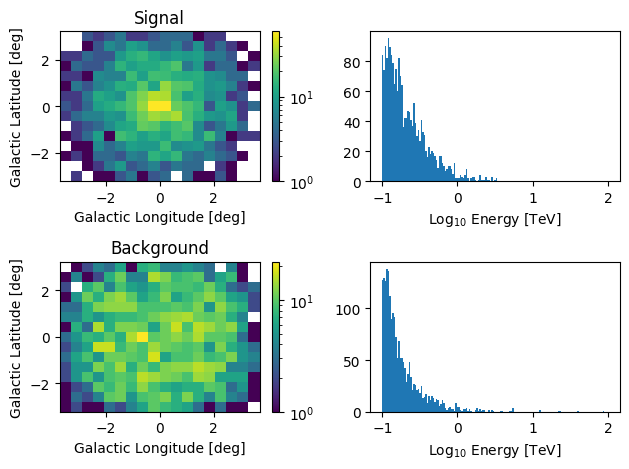

In [18]:
plot_loge_lon_lat_recon_samples(((signal_log10e_measured, signal_lon_measured, signal_lat_measured),
    (bkg_log10e_measured, bkg_lon_measured, bkg_lat_measured)),
    dist_names=('Signal', 'Background'))
plt.show()

## Final simulation output

In [19]:
measured_log10e = list(signal_log10e_measured)+list(bkg_log10e_measured)
measured_lon = list(signal_lon_measured)+list(bkg_lon_measured)
measured_lat = list(signal_lat_measured)+list(bkg_lat_measured)


# <h1><b>Analysis

## Marginalisation

In [21]:
nbinslogmass=51

if config_inputs['signalfraction']==0.0:
    nsig = 1
    logmasswindowwidth = log10eaxistrue.ptp()
else:
    nsig = int(round(config_inputs['signalfraction']*config_inputs['Nevents']))

    logmasswindowwidth      =6/np.sqrt(nsig)

logmasslowerbound       = config_inputs['logmass']-logmasswindowwidth
logmassupperbound       = config_inputs['logmass']+logmasswindowwidth

# if 1:
if logmasslowerbound<log10eaxis[0]:
    logmasslowerbound = log10eaxis[0]
# if 1:
if logmassupperbound>2:
    logmassupperbound = 2


logmassrange            = np.linspace(logmasslowerbound, logmassupperbound, nbinslogmass) 
print(f"logmass min, max, mean, range: {logmassrange.min(), logmassrange.max(), logmassrange.mean().round(3), logmassrange.ptp()}")

logmass min, max, mean, range: (0.36583592135001264, 0.6341640786499874, 0.5, 0.2683281572999747)


In [24]:
hyperparameter_likelihood_instance = hyperparameter_likelihood(priors=(DM_prior, bkg_prior,), likelihood=single_loglikelihood, 
                                                               dependent_axes=(log10eaxistrue,  longitudeaxistrue, latitudeaxistrue), dependent_logjacob=logjacobtrue,
                                                               hyperparameter_axes = ((logmassrange,), (None,)), numcores=config_inputs['numcores'], likelihoodnormalisation = psfnormalisationvalues+edispnormalisationvalues)

margresultsarray = np.array(hyperparameter_likelihood_instance.nuisance_log_marginalisation(axisvals= (measured_log10e, measured_lon, measured_lat)))

Setting up prior matrices: 100%|██████████| 2/2 [02:04<00:00, 62.04s/it] 
Performing parallelized direct event marginalisation: 100%|██████████| 4000/4000 [00:00<00:00, 991561.23it/s]
/Users/lpin0002/anaconda3/envs/testywesty/lib/python3.11/site-packages/gammabayes/likelihoods/instrument_response_funcs.py:116: RuntimeWarning: divide by zero encountered in log
  output = np.log(psffull.evaluate(energy_true=10**logetrue*u.TeV,
/Users/lpin0002/anaconda3/envs/testywesty/lib/python3.11/site-packages/gammabayes/likelihoods/instrument_response_funcs.py:120: RuntimeWarning: divide by zero encountered in log
  output+=np.log(edispfull.evaluate(energy_true=10**logetrue*u.TeV,


## Calculating posterior

In [26]:

nbins_sigfrac            = 151
sigfrac_windowwidth      = 9/np.sqrt(config_inputs['Nevents'])


sigfrac_lowerbound       = config_inputs['signalfraction']-sigfrac_windowwidth
sigfrac_upperbound       = config_inputs['signalfraction']+sigfrac_windowwidth




if sigfrac_lowerbound<0:
    sigfrac_lowerbound = 0
if sigfrac_upperbound>1:
    sigfrac_upperbound = 1


sigfrac_range   = np.linspace(sigfrac_lowerbound, sigfrac_upperbound, nbins_sigfrac) 

new_log_posterior = hyperparameter_likelihood_instance.create_mixture_log_hyper_likelihood(
    mixture_axes=(sigfrac_range,), log_margresults=margresultsarray)

log_posterior = np.squeeze(new_log_posterior - special.logsumexp(new_log_posterior))

endertimer = time.perf_counter()
print(endertimer-startertimer)

1020.6521869580029


# <h1><b>Plotting

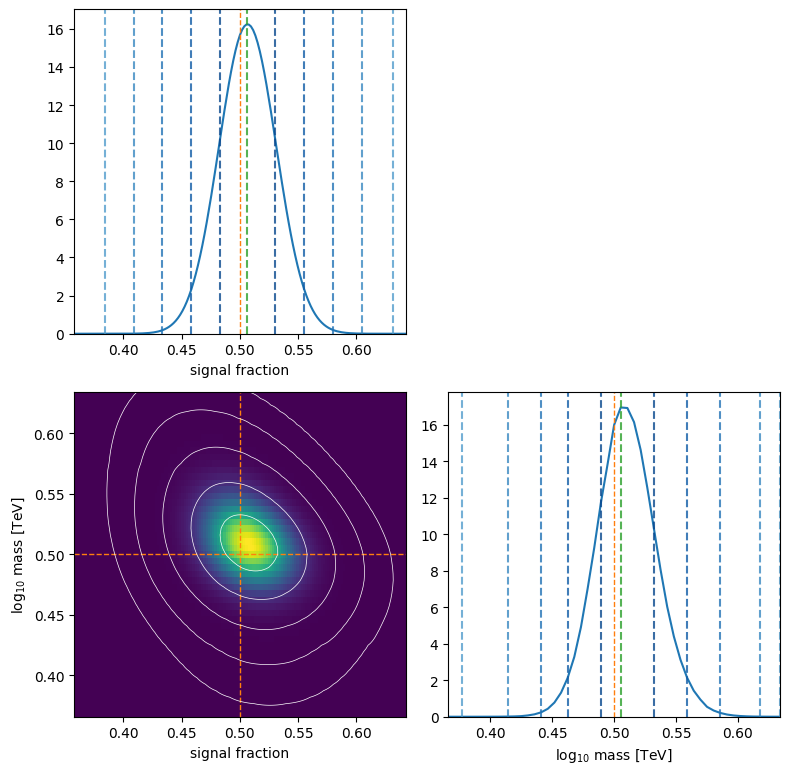

In [29]:
logdensity_matrix_plot(axes=(sigfrac_range, logmassrange,), logprobmatrix=log_posterior-special.logsumexp(log_posterior), 
                       truevals=(config_inputs['signalfraction'], config_inputs['logmass'],),
                       axis_names=('signal fraction', r'log$_{10}$ mass [TeV]', ), sigmalines=True,
                       dpi=100, figsize=(8,8))

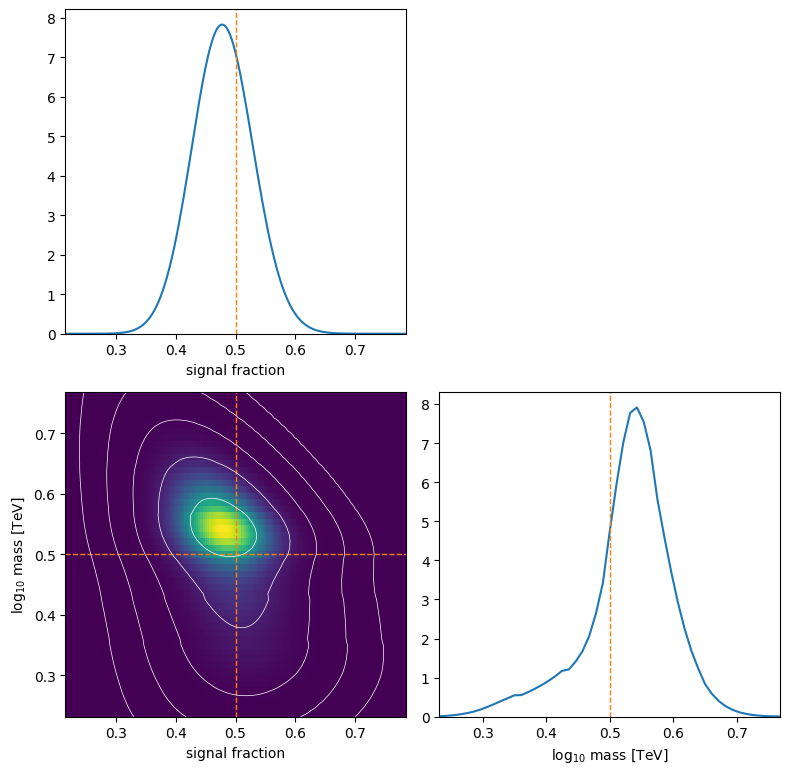

In [2]:
import numpy as np

fake_log10_eaxis_true = np.linspace(-1,2,301)

In [3]:
(len(fake_log10_eaxis_true)-1)/fake_log10_eaxis_true.ptp()


100.0